In [ ]:
!pip install gdown timm tqdm --quiet

import gdown

# Download from Google Drive
file_id = '123456789'  # Replace with the actual file ID
output_path = '/content/Insect_Dataset.tar.xz'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)
print(f"✅ Downloaded: {output_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA
From (redirected): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA&confirm=t&uuid=4a14b8a0-e5d8-4856-94e3-0375018bec5a
To: /content/Insect_Dataset.tar.xz
100%|██████████| 654M/654M [00:04<00:00, 153MB/s]

✅ Downloaded: /content/Insect_Dataset.tar.xz


In [2]:
!tar -xf Insect_Dataset.tar.xz
!ls /content/Insect_Dataset  # Verify classes (should show 15 folders)
print("✅ Dataset extracted!")

'alfalfa plant bug'   'brown plant hopper'	    'rice leaf roller'
'alfalfa weevil'      'corn borer'		    'rice shell pest'
'army worm'	      'green bug'		    'tarnished plant bug'
'asiatic rice borer'  'Mango flat beak leafhopper'  'white margined moth'
'beet fly'	      'paddy stem maggot'	    'yellow rice borer'
✅ Dataset extracted!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import random
import shutil
from tqdm import tqdm

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Transforms ready!")

✅ Transforms ready!


In [5]:
data_dir = '/content/Insect_Dataset'
split_dir = '/content/Insect_Dataset_Split'
os.makedirs(split_dir, exist_ok=True)

train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_dir, split), exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }

    for split, img_list in splits.items():
        dest_dir = os.path.join(split_dir, split, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for img in img_list:
            shutil.copy2(os.path.join(class_path, img), os.path.join(dest_dir, img))

first_train_class = os.listdir(os.path.join(split_dir, 'train'))[0]
num_train_images = len(os.listdir(os.path.join(split_dir, 'train', first_train_class)))

print("✅ Dataset split completed!")
print(f"Train: {num_train_images} images per class")

✅ Dataset split completed!
Train: 688 images per class


In [6]:
data_dir_split = '/content/Insect_Dataset_Split'

train_dataset = datasets.ImageFolder(os.path.join(data_dir_split, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir_split, 'val'), transform=val_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir_split, 'test'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"✅ Datasets loaded!")
print(f"Classes: {num_classes}")
print(f"Train batches: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

✅ Datasets loaded!
Classes: 15
Train batches: 392, Val: 49, Test: 50


In [7]:
# Create model (change variant if needed)
model = timm.create_model('mobilevit_s', pretrained=True, num_classes=num_classes)
# model = timm.create_model('mobilevit_xs', pretrained=True, num_classes=num_classes)
# model = timm.create_model('mobilevit_xxs', pretrained=True, num_classes=num_classes)

print(f"✅ MobileViT model created: {model.default_cfg['architecture']}")
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

✅ MobileViT model created: mobilevit_s
Total params: 4,947,247


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print(f"✅ Setup complete! Device: {device}")

✅ Setup complete! Device: cuda


In [9]:
EPOCHS = 20
best_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    train_loop = tqdm(train_loader, leave=False)
    for imgs, labels in train_loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

        train_loop.set_postfix({'loss': f"{train_loss/(train_loop.n+1):.4f}",
                               'acc': f"{100.*train_correct/train_total:.1f}"})

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total
    val_loss_avg = val_loss / len(val_loader)

    scheduler.step()

    print(f"Train: Loss={train_loss/len(train_loader):.4f}, Acc={train_acc:.2f}%")
    print(f"Val:   Loss={val_loss_avg:.4f}, Acc={val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_mobilevit.pth')
        print(f"💾 Best model saved! Val Acc: {best_acc:.2f}%")

print(f"\n🎉 Training done! Best Val Acc: {best_acc:.2f}%")


Epoch 1/20


Train: Loss=1.5503, Acc=55.00%
Val:   Loss=0.9201, Acc=71.46%
💾 Best model saved! Val Acc: 71.46%

Epoch 2/20


Train: Loss=1.0302, Acc=67.23%
Val:   Loss=0.7871, Acc=75.75%
💾 Best model saved! Val Acc: 75.75%

Epoch 3/20


Train: Loss=0.8936, Acc=71.45%
Val:   Loss=0.6757, Acc=78.83%
💾 Best model saved! Val Acc: 78.83%

Epoch 4/20


Train: Loss=0.7835, Acc=74.92%
Val:   Loss=0.6917, Acc=77.87%

Epoch 5/20


Train: Loss=0.7303, Acc=77.03%
Val:   Loss=0.5604, Acc=82.10%
💾 Best model saved! Val Acc: 82.10%

Epoch 6/20


Train: Loss=0.6538, Acc=79.17%
Val:   Loss=0.5538, Acc=83.64%
💾 Best model saved! Val Acc: 83.64%

Epoch 7/20


Train: Loss=0.6007, Acc=80.51%
Val:   Loss=0.5357, Acc=83.52%

Epoch 8/20


Train: Loss=0.5498, Acc=82.37%
Val:   Loss=0.5239, Acc=83.45%

Epoch 9/20


Train: Loss=0.5141, Acc=83.19%
Val:   Loss=0.5186, Acc=83.64%

Epoch 10/20


Train: Loss=0.5066, Acc=83.95%
Val:   Loss=0.5180, Acc=83.52%

Epoch 11/20


Train: Loss=0.4999, Acc=83.99%
Val:   Loss=0.5052, Acc=84.03%
💾 Best model saved! Val Acc: 84.03%

Epoch 12/20


Train: Loss=0.4939, Acc=84.28%
Val:   Loss=0.5093, Acc=84.22%
💾 Best model saved! Val Acc: 84.22%

Epoch 13/20


Train: Loss=0.4993, Acc=84.09%
Val:   Loss=0.5156, Acc=84.35%
💾 Best model saved! Val Acc: 84.35%

Epoch 14/20


Train: Loss=0.5081, Acc=83.82%
Val:   Loss=0.5265, Acc=84.28%

Epoch 15/20


Train: Loss=0.5210, Acc=83.41%
Val:   Loss=0.5412, Acc=83.71%

Epoch 16/20


Train: Loss=0.5411, Acc=82.77%
Val:   Loss=0.5403, Acc=84.09%

Epoch 17/20


Train: Loss=0.5408, Acc=82.70%
Val:   Loss=0.5878, Acc=82.42%

Epoch 18/20


Train: Loss=0.5565, Acc=82.12%
Val:   Loss=0.5856, Acc=82.42%

Epoch 19/20


Train: Loss=0.5483, Acc=82.10%
Val:   Loss=0.6223, Acc=82.49%

Epoch 20/20


Train: Loss=0.5496, Acc=82.15%
Val:   Loss=0.6490, Acc=80.89%

🎉 Training done! Best Val Acc: 84.35%


In [10]:
model.load_state_dict(torch.load('best_mobilevit.pth'))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n📊 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


📊 Classification Report
                            precision    recall  f1-score   support

Mango flat beak leafhopper       0.94      0.91      0.93        56
         alfalfa plant bug       0.80      0.85      0.83        82
            alfalfa weevil       0.72      0.75      0.74       108
                 army worm       0.88      0.91      0.90       410
        asiatic rice borer       0.71      0.47      0.56        51
                  beet fly       0.96      0.94      0.95        80
        brown plant hopper       0.86      0.79      0.82        90
                corn borer       0.81      0.78      0.79       108
                 green bug       0.73      0.61      0.67        72
         paddy stem maggot       0.69      0.76      0.72       106
          rice leaf roller       0.59      0.68      0.63        50
           rice shell pest       0.91      0.92      0.91        86
       tarnished plant bug       0.97      0.93      0.95       140
       white margined 

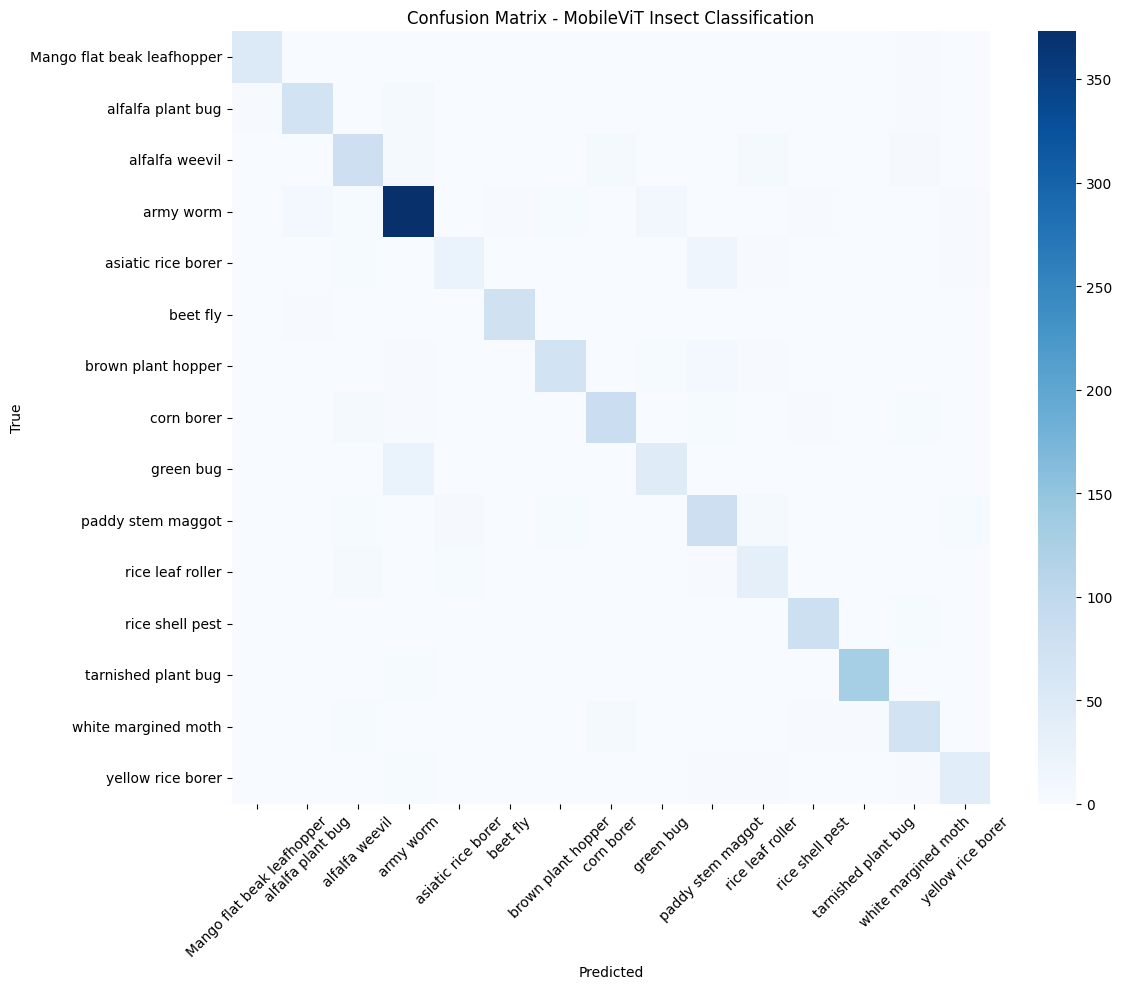

In [11]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.title("Confusion Matrix - MobileViT Insect Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
print("Model Architecture:")
print(model)
from torchsummary import summary
summary(model, (3, IMG_SIZE, IMG_SIZE), device=str(device))
# Install: !pip install torchsummary

Model Architecture:
ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Si